# Covid-19 data analysis for the Netherland
## uses covid data to learn datascience in pyhton with Jupyterlab

*Goals*
1. learning datawcience
2. learning python
3. learning Jupyterlab
4. maybe get some insight in covid

In [1]:
## install modules for Google Colab
# uncomment line below and run cell
#!pip install tabula-py cbsodata

In [2]:
#from IPython.display import Markdown as md
import os
import pandas as pd
import numpy as np
import cbsodata as cbs
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib widget
import tabula

#import numpy as np

## Revert to charts in pandas, for simplicity. 
#To DO: add Bokeh - https://docs.bokeh.org/
#from bokeh.io import output_notebook
#from bokeh.plotting import figure, show
#from bokeh.palettes import viridis
#import pandas_bokeh
#output_notebook()

In [3]:
# defining function for calculating percentage
def percentage(df, d, n):
    name = '%_'+d+'_OF_'+n
    df[name] = df[d]/df[n]*100
    df[name].replace(np.nan, 0, inplace=True)


def moving_average(df, n, p):
    name = 'mva_'+n
    windows = df[n].rolling(p)
    positive_tests[name] = windows.mean()


def running_total(df, n):
    name = 'rt_'+n
    df[name] = np.cumsum(df[n])

In [4]:
cbs_data_loc = './data/cbs_population.csv'
rivm_positive_tests_loc = './data/rivm_positive_tests.csv'

## Collecting data

### CBS
https://opendata.cbs.nl/statline/portal.html

In [5]:
print('Importing: Bevolkingsontwikkeling; maand en jaar 2002-now (Population statistics, month and year)')
try:
    os.stat(cbs_data_loc)
except:
    population = pd.DataFrame(cbs.get_data('37230ned'))
    population.to_csv(cbs_data_loc, index=False)
finally:
    population = pd.read_csv(cbs_data_loc, index_col='ID')
print('DONE')

Importing: Bevolkingsontwikkeling; maand en jaar 2002-now (Population statistics, month and year)
DONE


In [6]:
print('Preparing Dataframe for analyses')
print('Dropping unnecessary columns')
population = population.drop(columns=['BevolkingAanHetBeginVanDePeriode_1','TotaleVestiging_4',
       'VestigingVanuitEenAndereGemeente_5', 'Immigratie_6',
       'TotaalVertrekInclAdmCorrecties_7', 'VertrekNaarAndereGemeente_8',
       'EmigratieInclusiefAdmCorrecties_9', 'OverigeCorrecties_10',
       'Bevolkingsgroei_11', 'BevolkingsgroeiRelatief_12',
       'BevolkingsgroeiSinds1Januari_13',
       'BevolkingsgroeiSinds1JanuariRela_14'])
population = population.rename(columns={"LevendGeborenKinderen_2": "Born", "Overledenen_3": "Deceased", "BevolkingAanHetEindeVanDePeriode_15": "Population"})
print('DONE')

Preparing Dataframe for analyses
Dropping unnecessary columns
DONE


In [7]:
print('Setting PeriodIndex')
population['year'] = population.loc[:,'Perioden'].str.slice(stop=4)
population['month'] = population.loc[:,'Perioden'].str.slice(start=5)
population_y = population.loc[population['month'] == '',:]
population_y = population_y.drop(columns='month')
population_y = population_y.set_index(population_y['year'])
population_y.index = pd.PeriodIndex(population_y.index,freq='Y')

population = population.loc[population['month'] != '',:]
population['month'] = population.loc[:,'month'].replace({
    'januari': '01',
    'februari': '02',
    'maart': '03',
    'april': '04',
    'mei': '05',
    'juni': '06',
    'juli': '07',
    'augustus': '08',
    'september': '09',
    'oktober': '10',
    'november': '11',
    'december': '12'})

population = population.set_index(population['year'] + '-' + population['month'])
population.index = pd.PeriodIndex(population.index, freq='M')
print('DONE')

Setting PeriodIndex
DONE


In [8]:
print('Calculating percentage deceased of population')
percentage(population,'Deceased','Population')
percentage(population_y,'Deceased', 'Population')
print('DONE')

Calculating percentage deceased of population
DONE


In [9]:
print('Ceating dataframe for Nederland')
population_nl = population[population['RegioS'] == 'Nederland']
population = population[population['RegioS'] != 'Nederland']
population_y_nl = population_y[population_y['RegioS'] == 'Nederland']
population_y = population_y[population_y['RegioS'] != 'Nederland']
print('DONE')

Ceating dataframe for Nederland
DONE


<AxesSubplot:xlabel='month'>

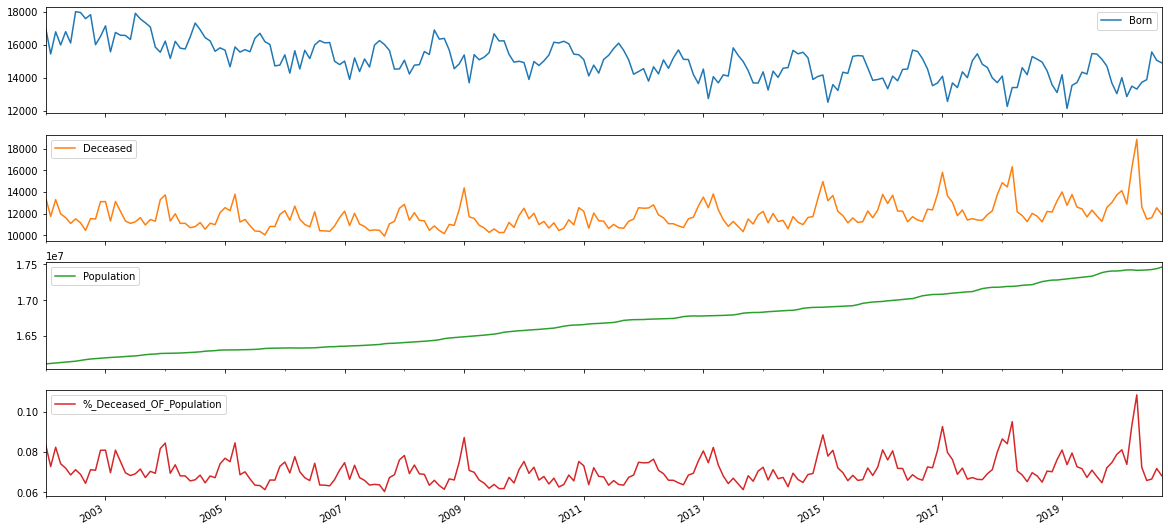

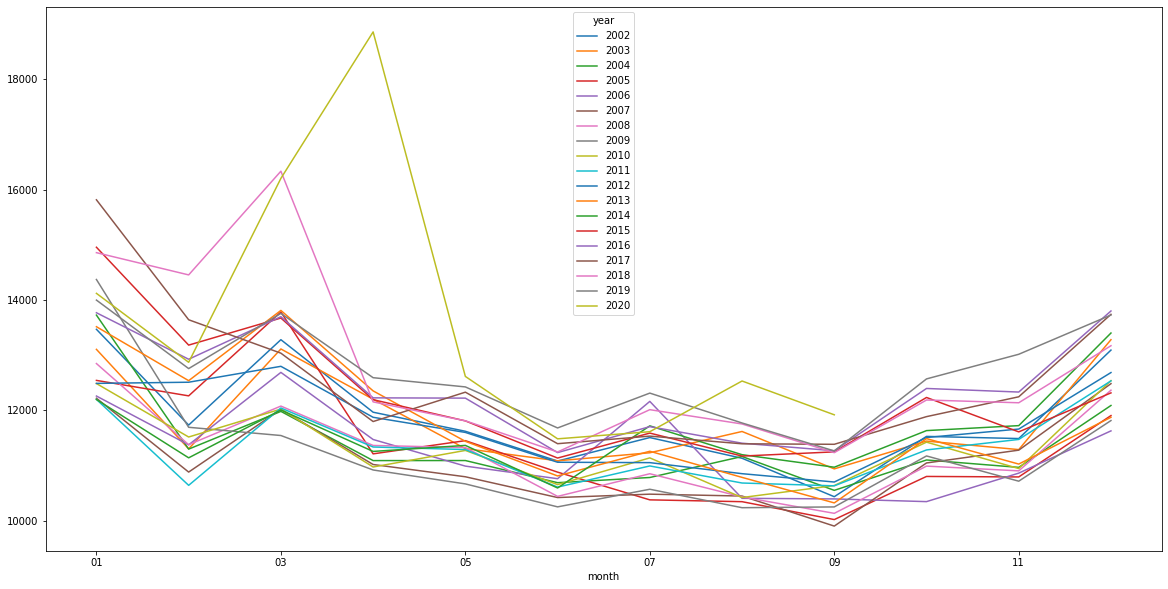

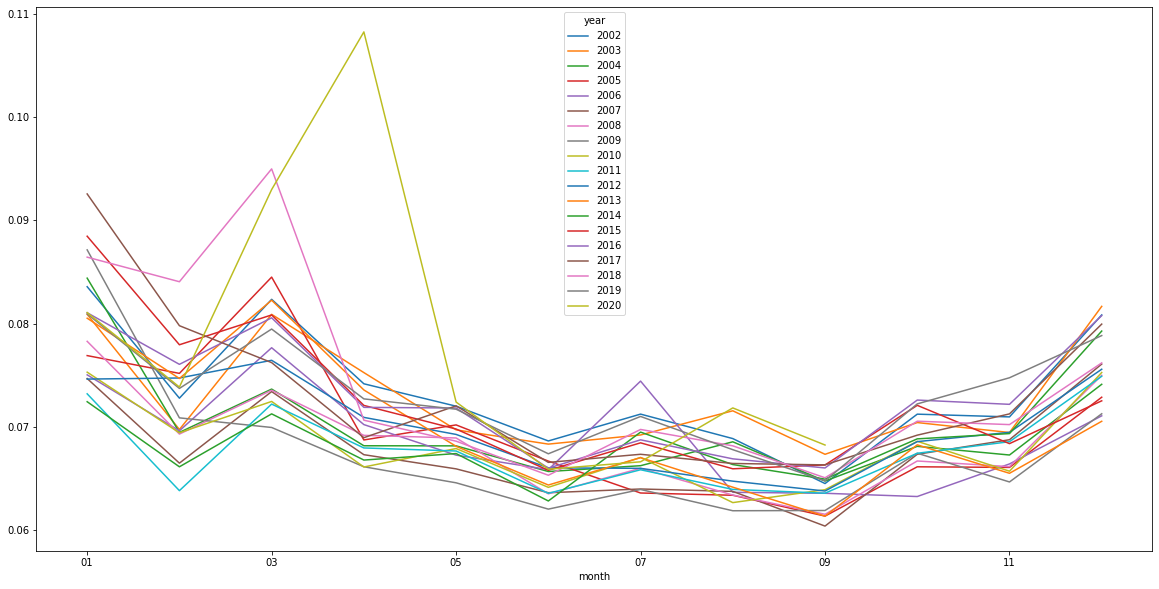

In [10]:
population_nl.plot(subplots=True,figsize=(20,10))
population_nl.pivot(index='month',columns='year', values='Deceased').plot(figsize=(20,10))
population_nl.pivot(index='month',columns='year',values='%_Deceased_OF_Population').plot(figsize=(20,10))

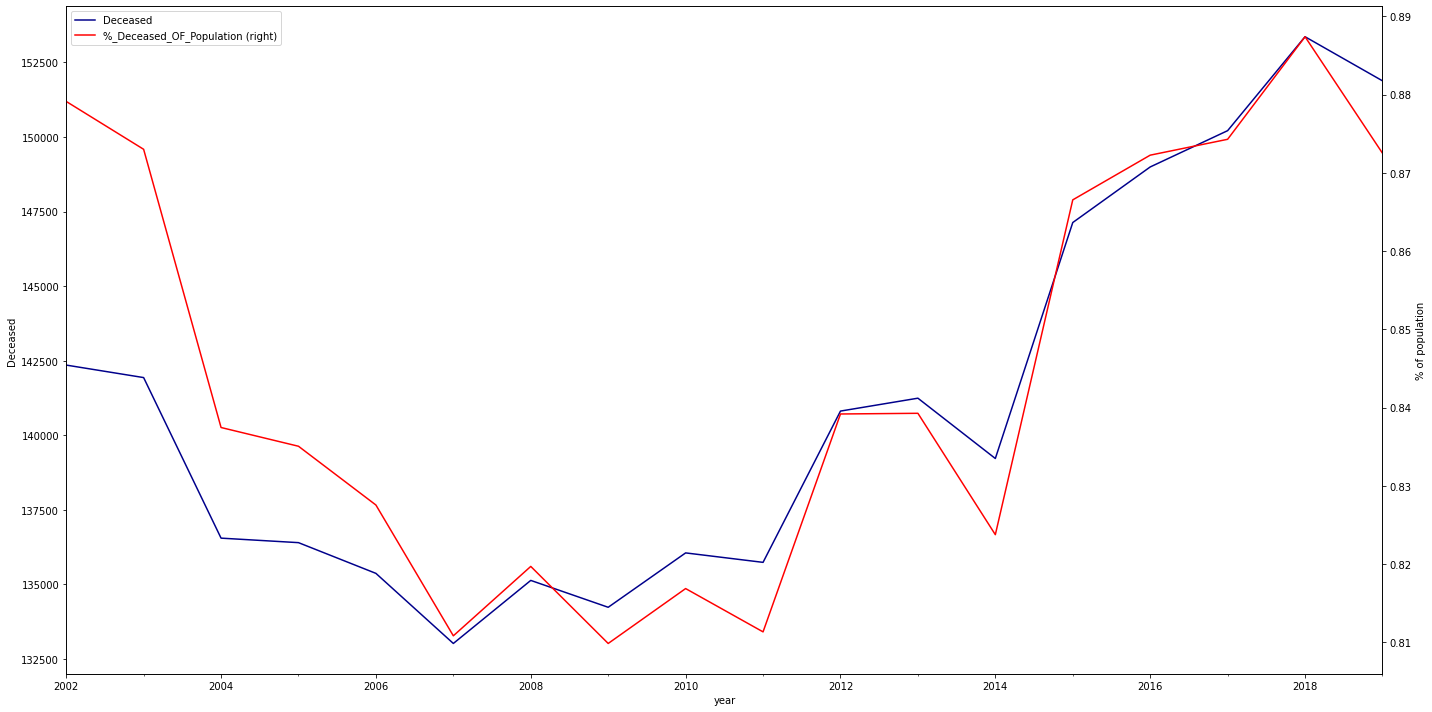

In [11]:
x=population_y_nl.index
ax=population_y_nl.plot(kind='line', y='Deceased', color='DarkBlue',figsize=(20,10))
ax2=population_y_nl.plot(kind='line',y='%_Deceased_OF_Population', secondary_y=True,color='Red', ax=ax)
ax.set_ylabel('Deceased')
ax2.set_ylabel('% of population')
plt.tight_layout()
plt.show()

In [12]:
#print('Ceating dataframe for Landsdeel')
print('SKIPPING Landsdeel')
#population_ld = population[population['RegioS'].str.slice(start=-4) == '(LD)']
population = population[population['RegioS'].str.slice(start=-4) != '(LD)']
#print('DONE')

print('Ceating dataframe for Provincies')
#print('SKIPPING Province')
population_pv = population[population['RegioS'].str.slice(start=-4) == '(PV)']
population_pv['RegioS'] = population_pv['RegioS'].str.slice(stop=-5)
population = population[population['RegioS'].str.slice(start=-4) != '(PV)']
print('DONE')

print('Ceating dataframe for COROP-gebied')
print('SKIPPING COROP-gebied')
#population_cr = population[population['RegioS'].str.slice(start=-4) == '(CR)']
population = population[population['RegioS'].str.slice(start=-4) != '(CR)']
#print('DONE')

print('Ceating dataframe for Gemeenten')
population_gm = population
print('DONE')
#del(population)

SKIPPING Landsdeel
Ceating dataframe for Provincies


/opt/conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


DONE
Ceating dataframe for COROP-gebied
SKIPPING COROP-gebied
Ceating dataframe for Gemeenten
DONE


<AxesSubplot:>

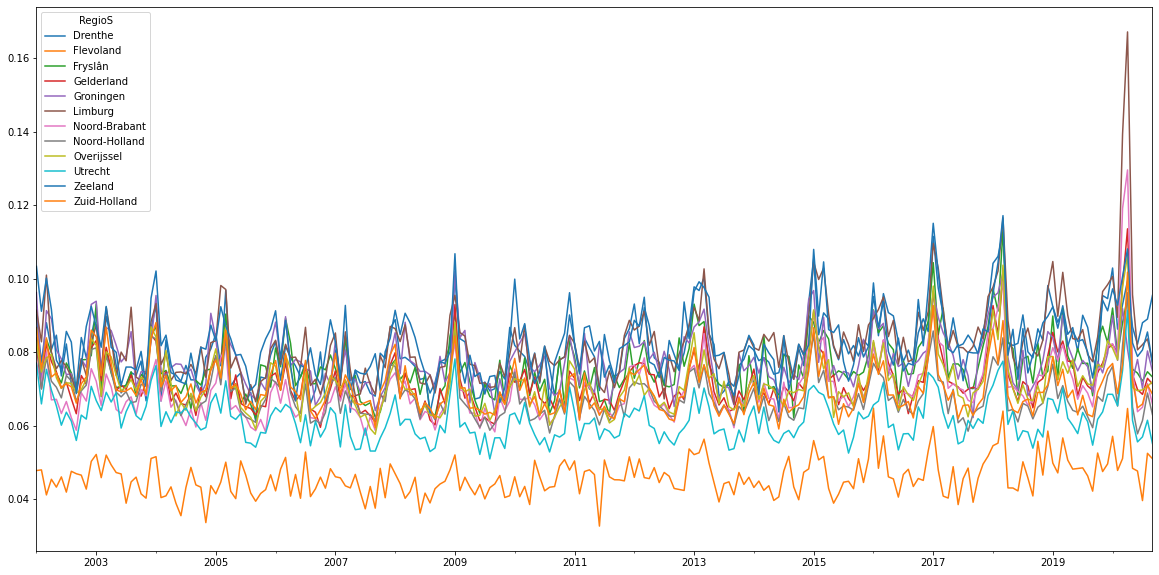

In [13]:
provincies = population_pv.pivot(columns='RegioS',values='%_Deceased_OF_Population')
provincies.plot(figsize=(20,10))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

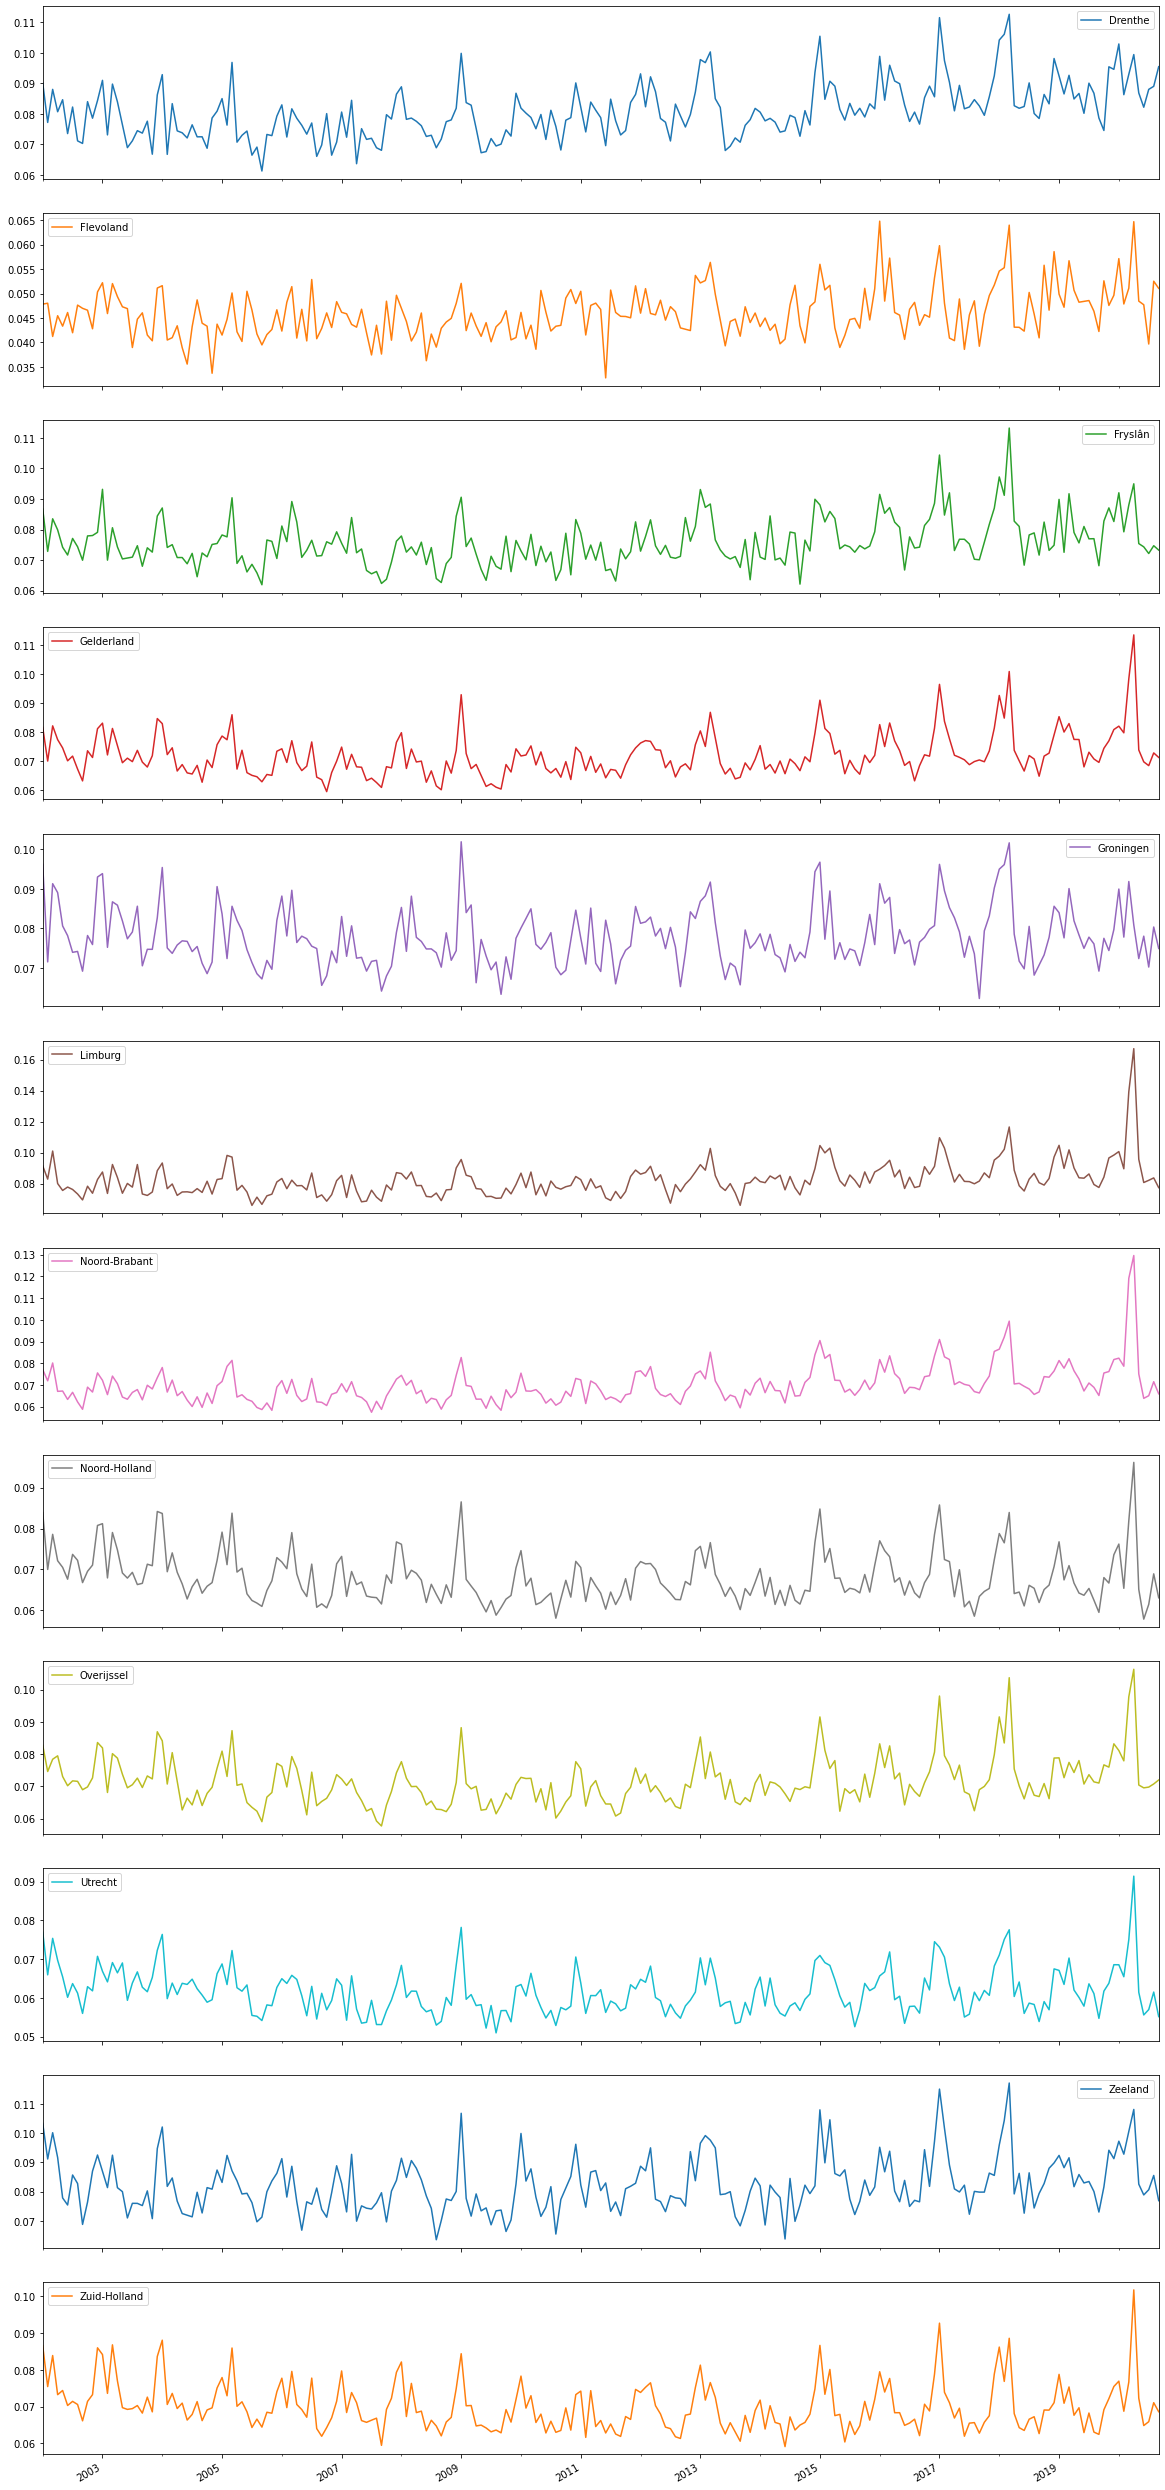

In [14]:
provincies.plot(figsize=(20,50),subplots=True)

<AxesSubplot:>

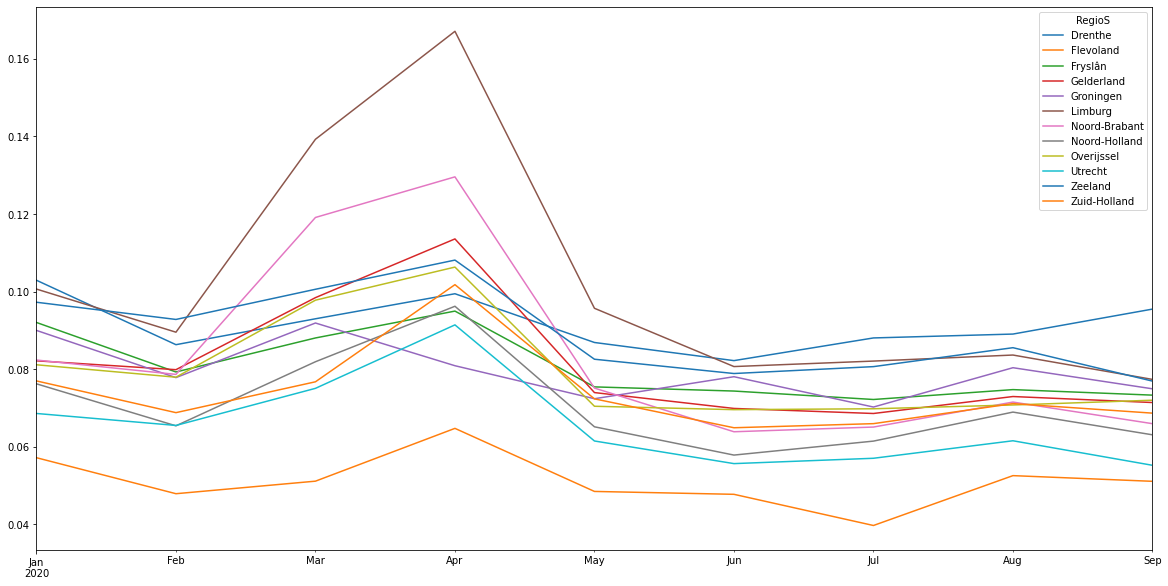

In [17]:
prov2020 = population_pv[population_pv.index >= '2020'].pivot(columns='RegioS',values='%_Deceased_OF_Population')
prov2020.plot(figsize=(20,10))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

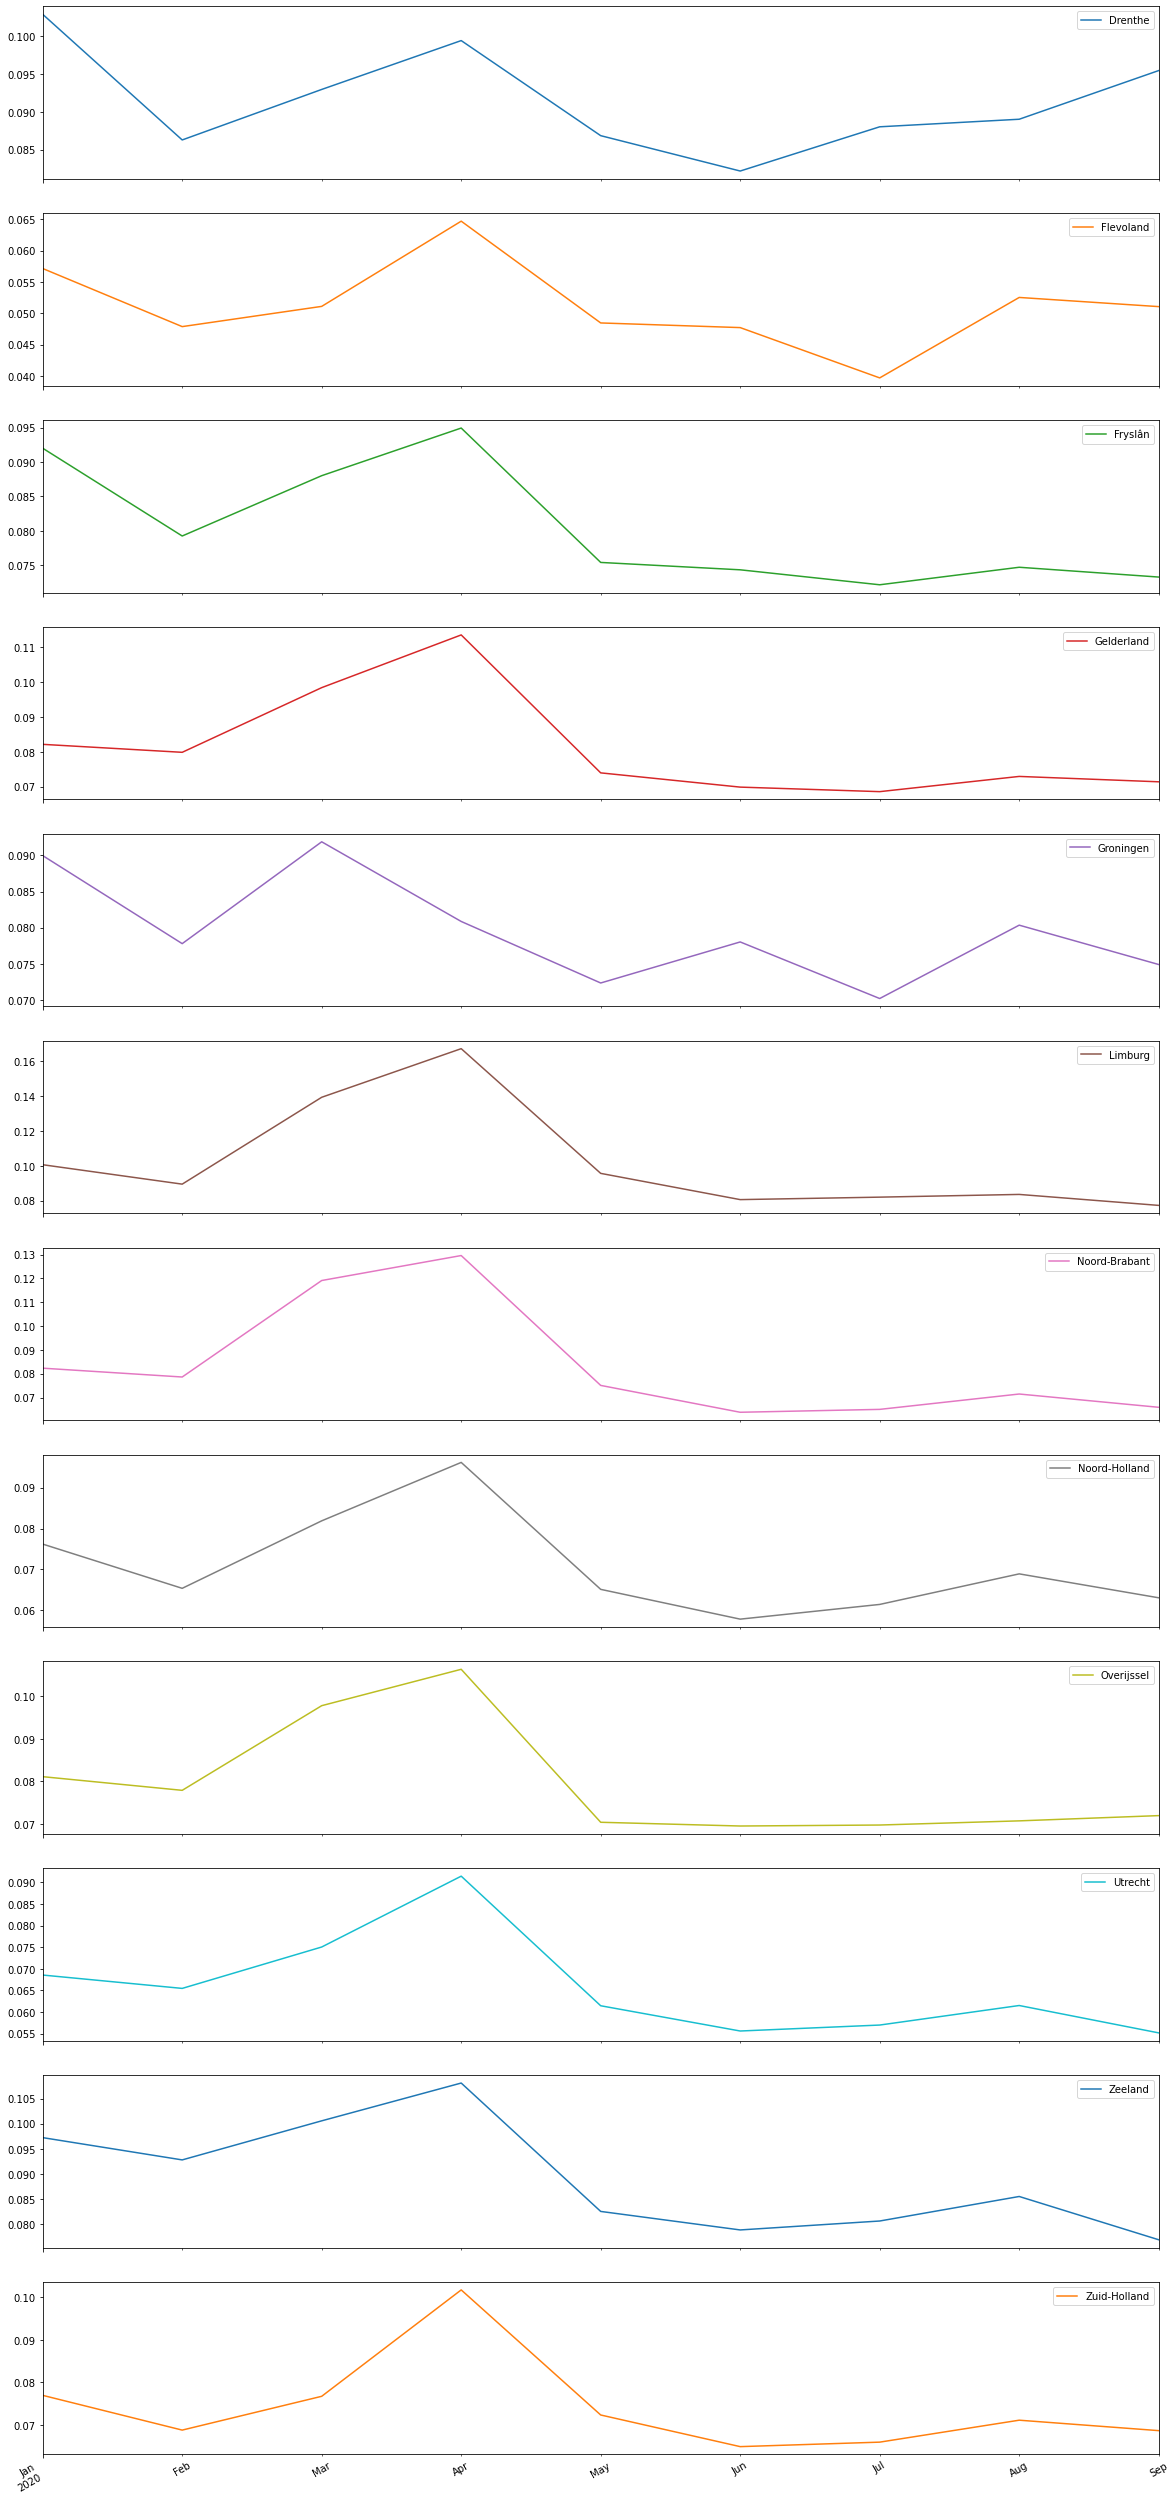

In [18]:
prov2020.plot(figsize=(20,50),subplots=True)

### and then reproducting the coronadashboard
The data I use is the sources used formhet Coronadashbord of the Dutch government. https://coronadashboard.rijksoverheid.nl/
  
This contains:
*medical indicators*

In [19]:
print("- number of positive tests") #https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427
url = 'https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_per_dag.json'
try:
    os.stat(rivm_positive_tests_loc)
except:
    positive_tests = pd.read_json(url)
    positive_tests.to_csv(rivm_positive_tests_loc, index=False)
finally:
    positive_tests = pd.read_csv(rivm_positive_tests_loc)
print('DONE')

- number of positive tests
DONE


In [20]:
rivm_date_of_report = positive_tests.loc[0,'Date_of_report']
print('Date of report for RIVM positive tests data = ' + str(rivm_date_of_report))
positive_tests = positive_tests.drop(columns='Date_of_report')

Date of report for RIVM positive tests data = 2020-11-26 10:00:00


In [21]:
# cumulatives
running_total(positive_tests, 'Total_reported')
running_total(positive_tests, 'Hospital_admission')
running_total(positive_tests, 'Deceased')

In [22]:
# percentages
percentage(positive_tests, 'rt_Deceased', 'rt_Total_reported')
percentage(positive_tests, 'rt_Deceased', 'rt_Hospital_admission')
percentage(positive_tests, 'rt_Hospital_admission', 'rt_Total_reported')

In [24]:
pfr = positive_tests.loc[positive_tests.index.argmax(),'%_rt_Deceased_OF_rt_Total_reported']
hfr = positive_tests.loc[positive_tests.index.argmax(),'%_rt_Deceased_OF_rt_Hospital_admission']
print('pfr on '+rivm_date_of_report+ 'is '+str(pfr)+'%')
print('hfr on '+rivm_date_of_report+ 'is '+str(hfr)+'%')

pfr on 2020-11-26 10:00:00is 1.8253985605905514%
hfr on 2020-11-26 10:00:00is 52.94287196633424%


<AxesSubplot:>

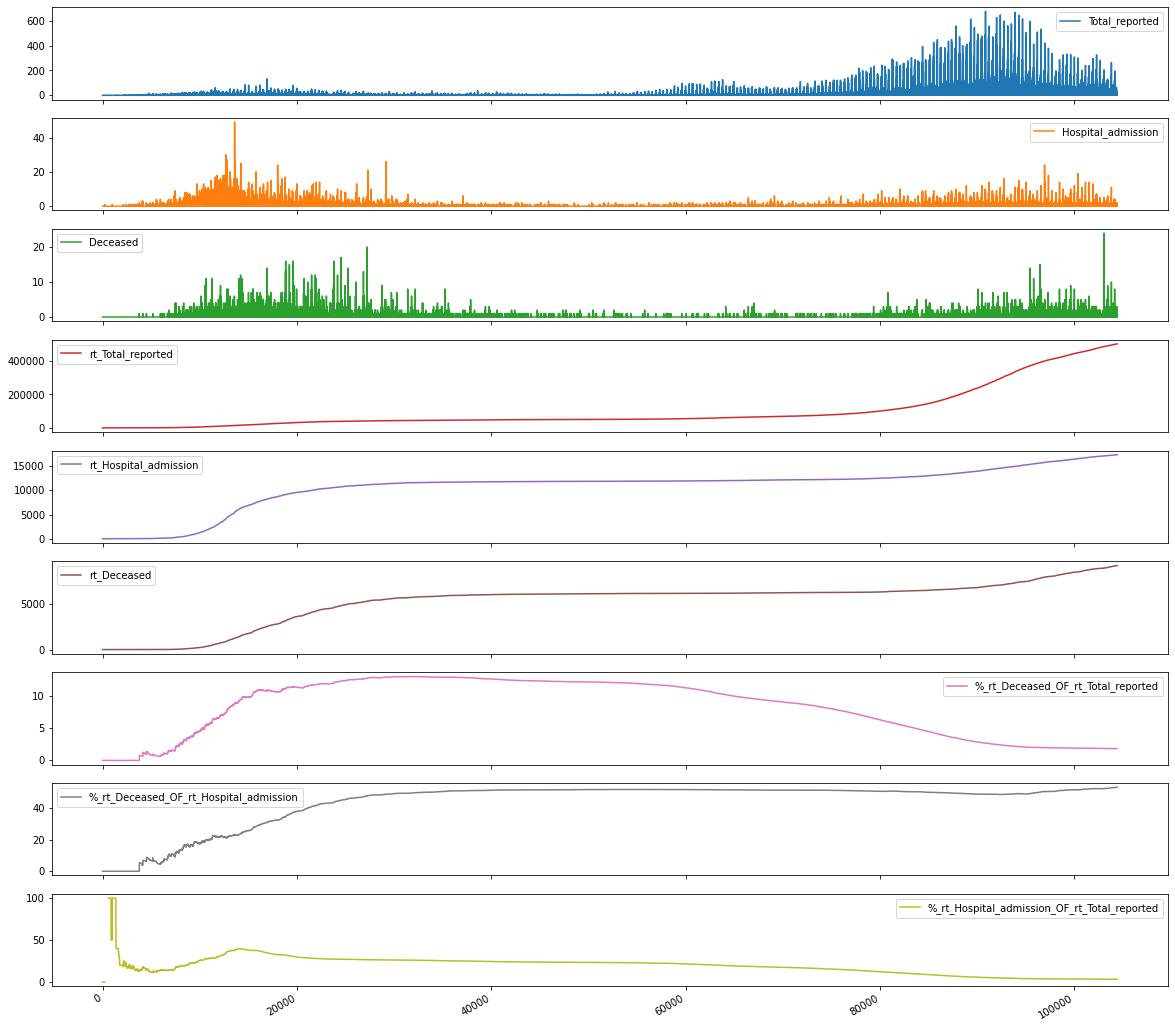

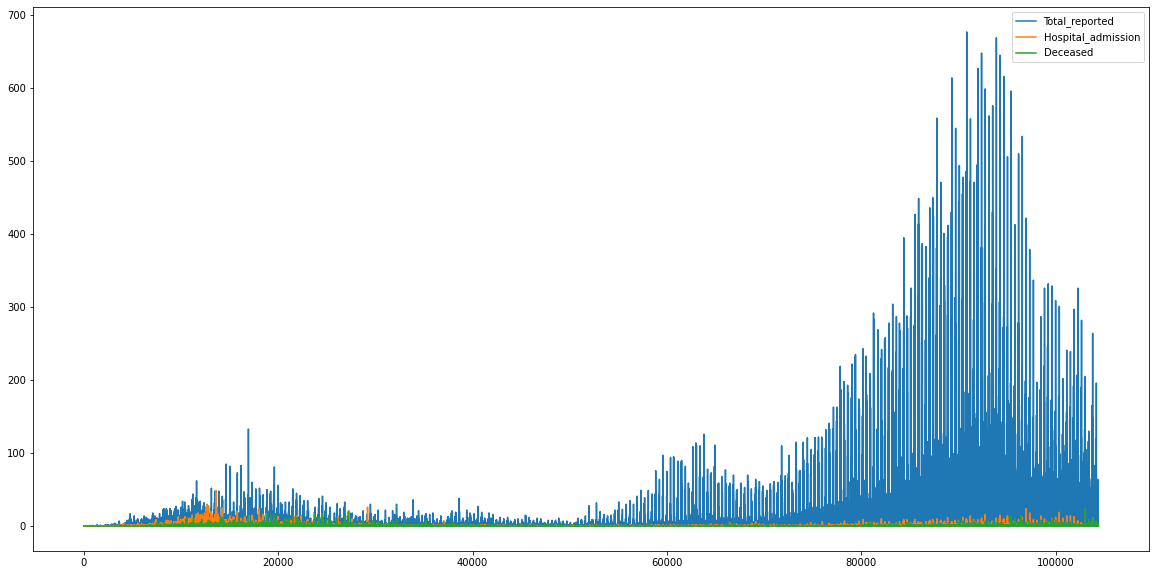

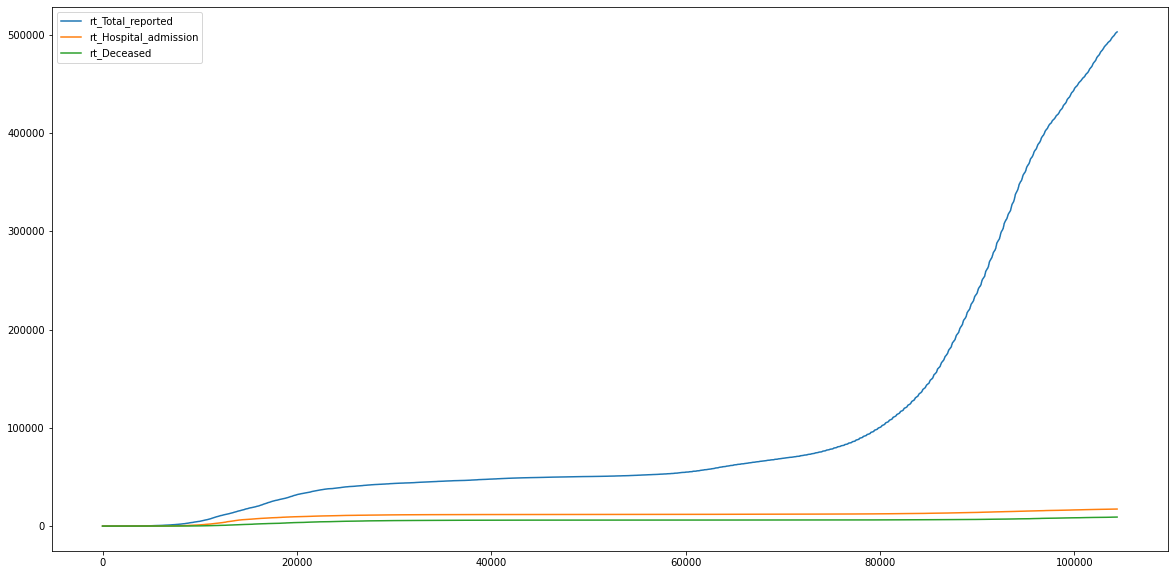

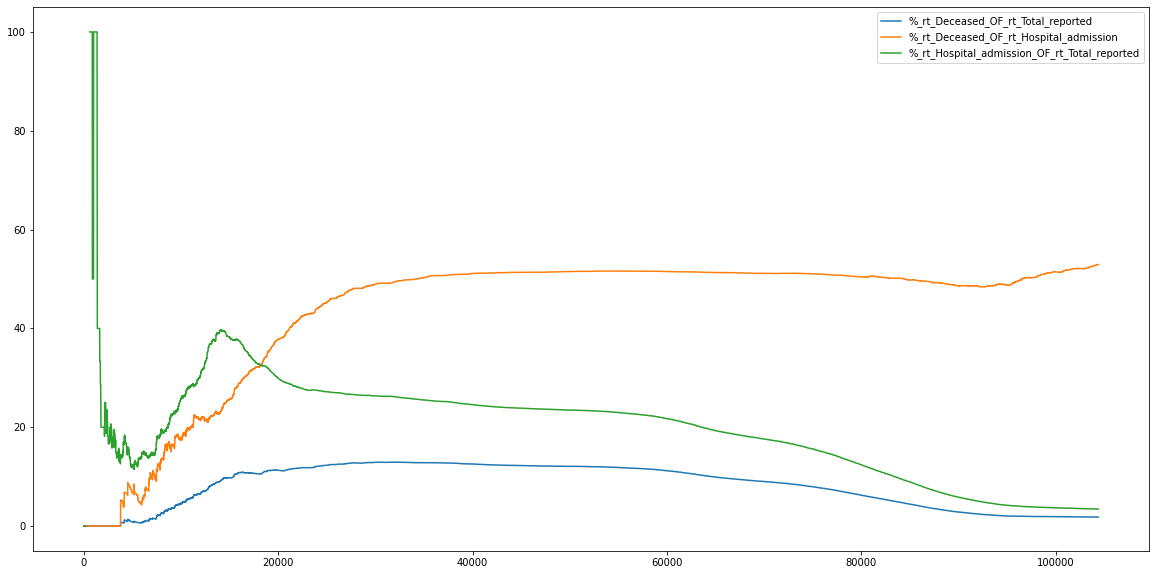

In [29]:
positive_tests.plot(figsize=(20,20),subplots=True)
positive_tests.plot(y=['Total_reported', 'Hospital_admission', 'Deceased'], figsize=(20, 10))
positive_tests.plot(y=['rt_Total_reported', 'rt_Hospital_admission', 'rt_Deceased'], figsize=(20, 10))
positive_tests.plot(y=['%_rt_Deceased_OF_rt_Total_reported', '%_rt_Deceased_OF_rt_Hospital_admission', '%_rt_Hospital_admission_OF_rt_Total_reported'], figsize=(20, 10))

In [ ]:
positive_tests = positive_tests.set_index(pd.PeriodIndex(positive_tests['Date_of_publication'], freq='d'))
positive_tests = positive_tests.drop(columns='Date_of_publication')
positive_tests['P'] = positive_tests.index.strftime('%Y-%m')
positive_tests = positive_tests.rename(index={'Date_of_publication':'date'})
positive_tests

In [ ]:
positive_tests_nl = positive_tests.sum(level='Date_of_publication')
positive_tests_nl['P'] = positive_tests_nl.index.strftime('%Y-%m')
positive_tests_nl

In [ ]:
pop_latest = population_nl.loc[population_nl['P'].max(),'Population']
pop_latest

In [ ]:
print(type(population_nl.P[0]))
print(type(positive_tests_nl.P[0]))

pd.merge_asof(positive_tests_nl,population_nl,left_on='P',right_on='P')

# Gemiddeld aantal positief geteste mensen per 100.000 inwoners
## Dit getal laat zien van hoeveel mensen gisteren per 100.000 inwoners gemeld is dat ze positief getest zijn en COVID-19 hebben.
positive_tests_nl['p100k'] = positive_tests_nl['Total_reported'] / population_nl.loc[if(positive_tests_nl['P'] > population_nl['P'].max()):
                                                                                     population_nl.loc[positive_tests_nl['P'],'Population']
                                                                                else:
                                                                                     positive_tests_nl['P']
                                                                                ,'Population'] * 100000


#pt_agg['mov_avg_p100k'] = np.average(pt_agg['']])
#np.mean(pt[len(pt.columns)-1].Total_reported)

In [ ]:
# Aantal positief geteste mensen
## Dit getal laat zien van hoeveel mensen gisteren gemeld is dat ze positief getest zijn en COVID-19 hebben.

In [ ]:
#Verdeling positief geteste mensen in Nederland
## per gemeente

## per veiligheidsregio



# TESTING BOKEH WITH OTHER DATA
pt_agg = pt.groupby(by=['Date_of_report'],as_index=False).sum()

q = figure(plot_width=800, plot_height=400, title="My Line Plot", x_axis_type="datetime")

q.multi_line(
    xs=[
        pt_agg['Date_of_report'],
        pt_agg['Date_of_report'],
        pt_agg['Date_of_report']
    ],
    ys=[
        pt_agg['Deceased'], 
        pt_agg['Hospital_admission'],
        pt_agg['Total_reported']
    ],
    color=viridis(len(pt_agg.columns)-1)
)

show(q)

In [ ]:
print("- Percentage positive tested of all tests done")
# https://www.rivm.nl/archief-weekrapportages-covid-19-in-nederland
pt_perc = tabula.read_pdf('https://www.rivm.nl/sites/default/files/2020-10/COVID-19_WebSite_rapport_wekelijks_20201013_1159_0.pdf', pages=29, guess=True, stream=True)
print(pt_perc)

## To DO:
## 1) extract data from latest pdf
## 2) scrape all pdfs for data to compare data thought time

In [ ]:
print("- number of infectious people")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/097155aa-75eb-4caa-8ed3-4c6edb80467e
infected = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_prevalentie.json')
print(infected.head())

In [ ]:
print("- R (reproductionnumber)")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/ed0699d1-c9d5-4436-8517-27eb993eab6e
R = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_reproductiegetal.json')
print(R.head())

In [ ]:
print("- hospital admissions per day")
# NICE https://www.databronnencovid19.nl/Bron?naam=Nationale-Intensive-Care-Evaluatie
hosp_nice = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-count/')
print(hosp_nice.head())
# LCPS https://lcps.nu/datafeed/
hosp_lcps = pd.read_csv('https://lcps.nu/wp-content/uploads/covid-19.csv')
print(hosp_lcps.head())
# Dashbaord changed source data https://www.nu.nl/coronavirus/6083846/ministerie-meldde-maandenlang-veel-te-weinig-opnames-coronapatienten.html
# other sources: https://www.stichting-nice.nl/covid-19-op-de-zkh.jsp
# 37852, 84522NED

In [ ]:
print("- icu admissions per day")
# url
ic_NICE_new_intake = pd.read_json('https://stichting-nice.nl/covid-19/public/new-intake/').T
ic_NICE_new_intake0 = pd.DataFrame()
for row in ic_NICE_new_intake[0]:
    ic_NICE_new_intake0 = ic_NICE_new_intake0.append(row, ignore_index=True)
print(ic_NICE_new_intake0)
ic_NICE_new_intake0['date'] = ic_NICE_new_intake['date']
ic_NICE_new_intake1 = pd.DataFrame()
for row in ic_NICE_new_intake[1]:
    ic_NICE_new_intake1 = ic_NICE_new_intake1.append(row, ignore_index=True)
ic_NICE_new_intake01 = pd.concat([ic_NICE_new_intake0,ic_NICE_new_intake1])
print(ic_NICE_new_intake01.head())
ic_NICE_new_intake_confirmed = pd.read_json('https://stichting-nice.nl/covid-19/public/new-intake/confirmed/')
#print(ic_NICE_new_intake_confirmed.head())
ic_NICE_intake_count = pd.read_json('https://stichting-nice.nl/covid-19/public/intake-count/')
#print(ic_NICE_intake_count.head())
print('IC data: 3 sources IMPORTED')
## To DO: conpare ic1 and ic2
#other sources: 

In [ ]:
ic_NICE_new_intake0

In [ ]:
# 84069NED

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_new_intake0 = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE new-intake")
# add a line renderer 
ic_new_intake0.line(
    ic_NICE_new_intake0['date'], 
    ic_NICE_new_intake0['value']
)
show(ic_new_intake0)

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_new_intake_confirmed = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE new-intake confirmed")
# add a line renderer 
ic_new_intake_confirmed.line(
    ic_NICE_new_intake_confirmed['date'], 
    ic_NICE_new_intake_confirmed['value']
)

# SINGLE LINE TEST
# create a new plot (with a title) using figure
ic_intake_count = figure(plot_width=800, plot_height=400, x_axis_type="datetime", title="NICE intake count")
# add a line renderer 
ic_intake_count.line(
    ic_NICE_intake_count['date'], 
    ic_NICE_intake_count['value']
)

## MULTIPLE LINE TEST
ic_all = figure(title="IC1 & IC_opnames_NICE", plot_width=800, plot_height=400, x_axis_type="datetime")

ic_all.multi_line([ic1.date, ic_opnames.date],
              [ic1.value, ic_opnames.value],
              color=viridis(3))

show(ic_new_intake)
show(ic_new_intake_confirmed)
show(ic_intake_count)
show(ic_all)

In [ ]:
## sources NICE for their website:
# /covid-19/public/zkh/global
# /covid-19/public/zkh/new-intake/
# /covid-19/public/zkh/intake-count/
# /covid-19/public/zkh/intake-cumulative/
# /covid-19/public/zkh/died-and-survivors-cumulative/
# /covid-19/public/zkh/age-distribution-died-and-survivors/
# /covid-19/public/zkh/age-distribution-status/
# /covid-19/public/zkh/behandelduur-distribution/
# /covid-19/public/zkh/behandelduur-distribution/
## TO DO: check which used and which to use extra.
## sources LCPS?
# https://lcps.nu/wp-content/uploads/
## Maybe scrape website to find more public data: https://scrapy.org/ OR https://www.crummy.com/software/BeautifulSoup/bs4/doc/

*early signs*

In [ ]:
print("- patient reporting covid symptoms at family doctor")
# https://www.nivel.nl/nl/nivel-zorgregistraties-eerste-lijn/nivel-zorgregistraties-eerste-lijn


In [ ]:
print("- sewagewate")
# https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/a2960b68-9d3f-4dc3-9485-600570cd52b9
sw = pd.read_json('https://data.rivm.nl/covid-19/COVID-19_rioolwaterdata.json')
print(sw.head())

*homes for elderly*

In [ ]:
print("- positive testst")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

In [ ]:
print("- infected locations")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

In [ ]:
print("- number deseased")
# from pdf. https://www.rivm.nl/documenten/wekelijkse-update-epidemiologische-situatie-covid-19-in-nederland

**metadata**

In [ ]:
print("- municipalities in Netherlands")
## https://www.cbs.nl/nl-nl/onze-diensten/methoden/classificaties/overig/gemeentelijke-indelingen-per-jaar/indeling%20per%20jaar/gemeentelijke-indeling-op-1-januari-2020
municipality = pd.read_excel('https://www.cbs.nl/-/media/_excel/2020/03/gemeenten-alfabetisch-2020.xlsx')
print(municipality.head())
# aantallen per gemeente: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427


### missing data, i would like to calculate of collect
- covid numbers relitive to all data
- deseased for whole country (possible source: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/1c0fcd57-1102-4620-9cfa-441e93ea5604)

### more data

- Karakteristieken elke geteste persoon: https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/2c4357c8-76e4-4662-9574-1deb8a73f724?tab=relations
- https://data.rivm.nl

In [ ]:
#check data collection
from pivottablejs import pivot_ui
from IPython.display import HTML

df_to_check = ic1

pivot_ui(df_to_check, outfile_path='pivottablejs.html')
HTML('pivottablejs.html')